# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 35kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

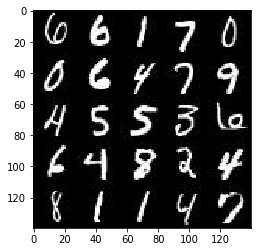

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

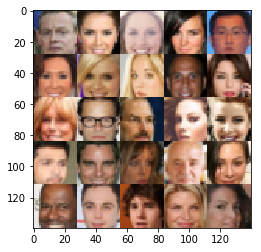

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), \
                                 name = 'input_real')
                                
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    
    learning_rate = tf.placeholder(tf.float32, name ='lr')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.18, is_train = True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse = reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same') #14, 14, 64
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train) #7, 7, 128
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 4, strides = 2, padding = 'valid')
        x3 = tf.layers.batch_normalization(x3, training = is_train) #2, 2, 256
        x3 = tf.maximum(alpha*x3, x3)
        x3= tf.layers.dropout(x3, rate = 0.2) #Applying Dropout to the Final output of leaky relu
        
        x3 = tf.reshape(x3, (-1, 2*2*256)) # flatten it
        logits = tf.layers.dense(x3, 1, kernel_initializer=tf.truncated_normal_initializer(0,0.02)) 
        #Applying Normal weight initialization
        
        out = tf.nn.sigmoid(logits)
        
        return out, logits




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.18, reuse = False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse = not is_train): # Not operator to cover both cases of training and 
                                                                #inference?
        x1 = tf.layers.dense(z, 3*3*1024)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x1024 now
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 6x6x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x128
        x5 = tf.layers.conv2d_transpose(x4, 64, 5, strides=1, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        # 28*28*64
        
        x5 = tf.layers.dropout(x5, rate = 0.2)
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
    
    
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.18):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z,out_channel_dim, alpha=alpha, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False, alpha=alpha, is_train=True)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, is_train=True)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, 
                                                                    labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                           labels = tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                           labels = tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False), # is_train is false therefore, reuse will be True when displaying
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    alpha = 0.18
    showevery = 100
    printevery = 10
    steps = 0
    losses =[]
    _, width, height, channels = data_shape
    
    inputs_real, inputs_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, channels, alpha=alpha)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images*2 # As the real image data is from -0.5 to +0.5 rescale to tanh output

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                
                
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z,
                                                     lr: learning_rate}) #Both real and gen output as Input
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images,
                                                   lr: learning_rate}) # running it twice with z noise/real input
                
            
                
                #d_loss_vec.append(d)
                #g_loss_vec.append(g)
                    

                if steps % printevery == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Step {}...".format(steps),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % showevery == 0:
                    show_generator_output(sess, 9, inputs_z, channels, data_image_mode )

        
    print ("Training complete")        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 10... Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 2.9998
Step 20... Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.7581
Step 30... Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.9314
Step 40... Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.1753
Step 50... Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 1.0517
Step 60... Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.9875
Step 70... Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8301
Step 80... Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 1.1100
Step 90... Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.1669
Step 100... Epoch 1/1... Discriminator Loss: 1.6444... Generator Loss: 0.5711


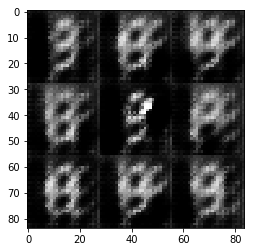

Step 110... Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7756
Step 120... Epoch 1/1... Discriminator Loss: 1.7441... Generator Loss: 0.4514
Step 130... Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.8348
Step 140... Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7188
Step 150... Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6348
Step 160... Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.6733
Step 170... Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7237
Step 180... Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.7057
Step 190... Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7867
Step 200... Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7466


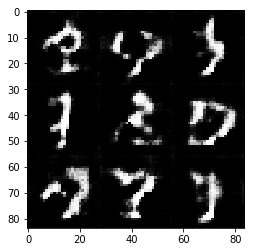

Step 210... Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7043
Step 220... Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7457
Step 230... Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.8116
Step 240... Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7227
Step 250... Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6365
Step 260... Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.8139
Step 270... Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6672
Step 280... Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7330
Step 290... Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.6209
Step 300... Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7041


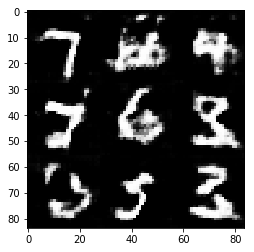

Step 310... Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.6207
Step 320... Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.5409
Step 330... Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6527
Step 340... Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.7531
Step 350... Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7767
Step 360... Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7339
Step 370... Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.6905
Step 380... Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6466
Step 390... Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7338
Step 400... Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.6236


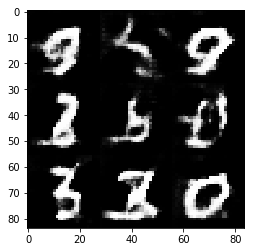

Step 410... Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6508
Step 420... Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.8068
Step 430... Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.5475
Step 440... Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6684
Step 450... Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6814
Step 460... Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.6535
Step 470... Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6685
Step 480... Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.7642
Step 490... Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7143
Step 500... Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6976


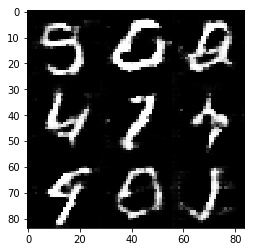

Step 510... Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7426
Step 520... Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7331
Step 530... Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7197
Step 540... Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6734
Step 550... Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.7632
Step 560... Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7242
Step 570... Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6991
Step 580... Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6785
Step 590... Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.7073
Step 600... Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.6270


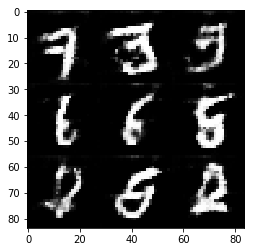

Step 610... Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7034
Step 620... Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7251
Step 630... Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.9421
Step 640... Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.6987
Step 650... Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.6805
Step 660... Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.6779
Step 670... Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.5813
Step 680... Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.6882
Step 690... Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 1.1078
Step 700... Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.5827


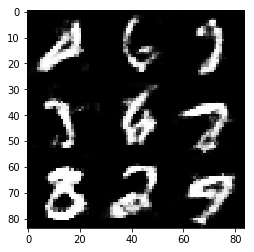

Step 710... Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.6645
Step 720... Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8391
Step 730... Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.8818
Step 740... Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7273
Step 750... Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.7341
Step 760... Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.7754
Step 770... Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 1.0229
Step 780... Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.7771
Step 790... Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.6876
Step 800... Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.6183


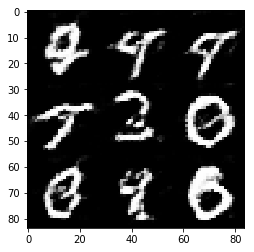

Step 810... Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.9268
Step 820... Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6303
Step 830... Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.5450
Step 840... Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.5267
Step 850... Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.8203
Step 860... Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.5673
Step 870... Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.8165
Step 880... Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.7008
Step 890... Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7132
Step 900... Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 1.1687


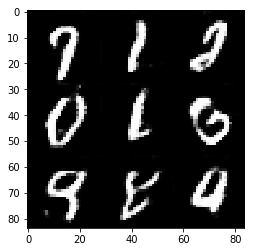

Step 910... Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.7070
Step 920... Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.9677
Step 930... Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.5776
Step 940... Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.5659
Step 950... Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.6812
Step 960... Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6642
Step 970... Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.9265
Step 980... Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7993
Step 990... Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.6078
Step 1000... Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.9471


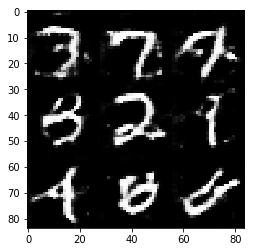

Step 1010... Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.7877
Step 1020... Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.7219
Step 1030... Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.5507
Step 1040... Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.6254
Step 1050... Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.6189
Step 1060... Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.5049
Step 1070... Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.6552
Step 1080... Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.6641
Step 1090... Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.6939
Step 1100... Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.8395


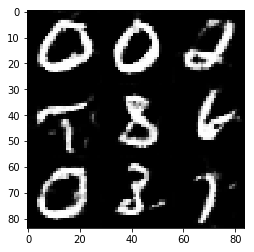

Step 1110... Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.5940
Step 1120... Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.4611
Step 1130... Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.9361
Step 1140... Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.7313
Step 1150... Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.9255
Step 1160... Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.6441
Step 1170... Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 1.0276
Step 1180... Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.8506
Step 1190... Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.8589
Step 1200... Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.7947


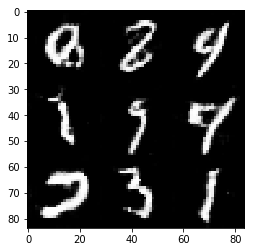

Step 1210... Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7070
Step 1220... Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7089
Step 1230... Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.8557
Step 1240... Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.9165
Step 1250... Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.7795
Step 1260... Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7670
Step 1270... Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.8917
Step 1280... Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 1.0347
Step 1290... Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 1.0070
Step 1300... Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.8145


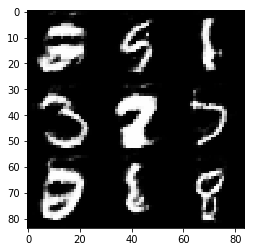

Step 1310... Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7395
Step 1320... Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.6668
Step 1330... Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.6317
Step 1340... Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.5029
Step 1350... Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.4268
Step 1360... Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.6936
Step 1370... Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.9365
Step 1380... Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.9273
Step 1390... Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.8682
Step 1400... Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7056


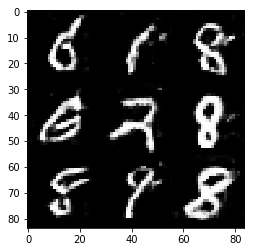

Step 1410... Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.9833
Step 1420... Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 1.0311
Step 1430... Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.4966
Step 1440... Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7935
Step 1450... Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.7315
Step 1460... Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.5471
Step 1470... Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.8392
Step 1480... Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.5644
Step 1490... Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.1685
Step 1500... Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.4801


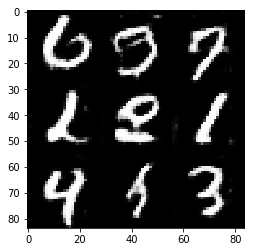

Step 1510... Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 1.1757
Step 1520... Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.8610
Step 1530... Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 0.8919
Step 1540... Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.5223
Step 1550... Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.5446
Step 1560... Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.7616
Step 1570... Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.7163
Step 1580... Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.9835
Step 1590... Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.7218
Step 1600... Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.5800


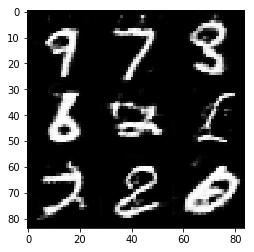

Step 1610... Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.9917
Step 1620... Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.8056
Step 1630... Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.7710
Step 1640... Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.8823
Step 1650... Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7346
Step 1660... Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.7980
Step 1670... Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.5464
Step 1680... Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 1.1867
Step 1690... Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.8468
Step 1700... Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.6673


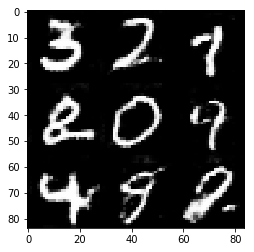

Step 1710... Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.6616
Step 1720... Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.8284
Step 1730... Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.7391
Step 1740... Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.7443
Step 1750... Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8344
Step 1760... Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.8590
Step 1770... Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.7428
Step 1780... Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.8137
Step 1790... Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.7231
Step 1800... Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.7662


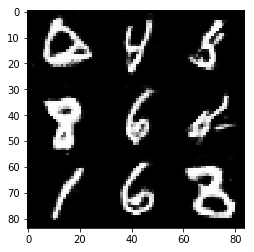

Step 1810... Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.8751
Step 1820... Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 1.1787
Step 1830... Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8284
Step 1840... Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 0.8646
Step 1850... Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.6912
Step 1860... Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.6915
Step 1870... Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 0.9905
Training complete


In [42]:
batch_size = 32
z_dim = 500
learning_rate = 0.0005
beta1 = 0.35


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 10... Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 2.3114
Step 20... Epoch 1/1... Discriminator Loss: 0.4270... Generator Loss: 2.4883
Step 30... Epoch 1/1... Discriminator Loss: 0.4614... Generator Loss: 2.1333
Step 40... Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 2.0606
Step 50... Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 3.4985
Step 60... Epoch 1/1... Discriminator Loss: 0.6532... Generator Loss: 5.5411
Step 70... Epoch 1/1... Discriminator Loss: 2.0639... Generator Loss: 0.2504
Step 80... Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.9620
Step 90... Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.7899
Step 100... Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 2.0483


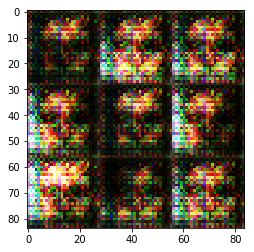

Step 110... Epoch 1/1... Discriminator Loss: 1.6905... Generator Loss: 0.3620
Step 120... Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 1.2051
Step 130... Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.4903
Step 140... Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.9771
Step 150... Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.5364
Step 160... Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.9254
Step 170... Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7619
Step 180... Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.8295
Step 190... Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6445
Step 200... Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.5814


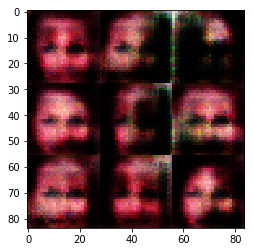

Step 210... Epoch 1/1... Discriminator Loss: 1.7905... Generator Loss: 0.3093
Step 220... Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8511
Step 230... Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.6446
Step 240... Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.5053
Step 250... Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.9535
Step 260... Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.8334
Step 270... Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6355
Step 280... Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7250
Step 290... Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.5984
Step 300... Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.9282


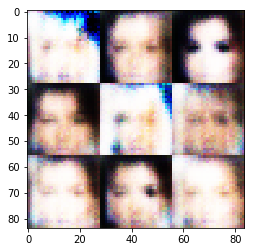

Step 310... Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7248
Step 320... Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7987
Step 330... Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7947
Step 340... Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6359
Step 350... Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6118
Step 360... Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.7447
Step 370... Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7079
Step 380... Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.7922
Step 390... Epoch 1/1... Discriminator Loss: 1.6267... Generator Loss: 0.4411
Step 400... Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.5603


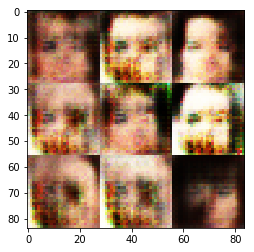

Step 410... Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.5630
Step 420... Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.7207
Step 430... Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.5905
Step 440... Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.6699
Step 450... Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7035
Step 460... Epoch 1/1... Discriminator Loss: 1.6273... Generator Loss: 0.5147
Step 470... Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 1.0279
Step 480... Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.5525
Step 490... Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7504
Step 500... Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.9049


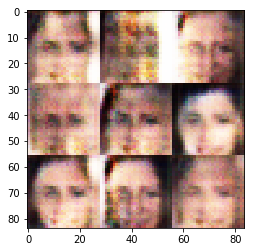

Step 510... Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 1.0427
Step 520... Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6881
Step 530... Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.5263
Step 540... Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7702
Step 550... Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6610
Step 560... Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.5885
Step 570... Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.8024
Step 580... Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6911
Step 590... Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.5933
Step 600... Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.5368


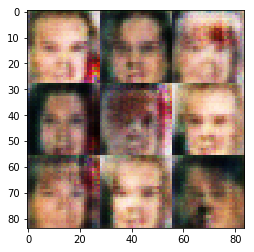

Step 610... Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8321
Step 620... Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.7914
Step 630... Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.5633
Step 640... Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.6753
Step 650... Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.6329
Step 660... Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7541
Step 670... Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6616
Step 680... Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6740
Step 690... Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.6223
Step 700... Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8261


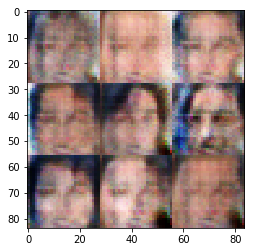

Step 710... Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6476
Step 720... Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.6641
Step 730... Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7137
Step 740... Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.8060
Step 750... Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6773
Step 760... Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7633
Step 770... Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.6990
Step 780... Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.5618
Step 790... Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7248
Step 800... Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6847


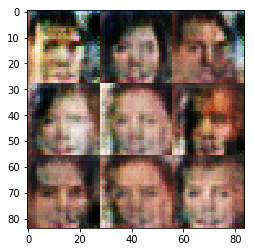

Step 810... Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.8442
Step 820... Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.6316
Step 830... Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7988
Step 840... Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7164
Step 850... Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6896
Step 860... Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.7741
Step 870... Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7071
Step 880... Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6793
Step 890... Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7172
Step 900... Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.6826


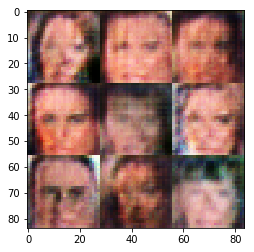

Step 910... Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.7207
Step 920... Epoch 1/1... Discriminator Loss: 1.5728... Generator Loss: 0.6151
Step 930... Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.5868
Step 940... Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.7684
Step 950... Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.7533
Step 960... Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7225
Step 970... Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7420
Step 980... Epoch 1/1... Discriminator Loss: 1.5890... Generator Loss: 0.6716
Step 990... Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.6474
Step 1000... Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8233


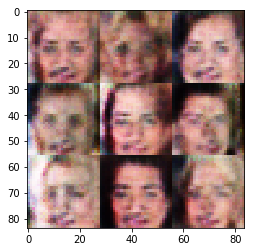

Step 1010... Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6425
Step 1020... Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7262
Step 1030... Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7225
Step 1040... Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6970
Step 1050... Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.6730
Step 1060... Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.5890
Step 1070... Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7116
Step 1080... Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6571
Step 1090... Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6409
Step 1100... Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.5988


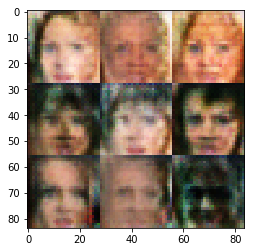

Step 1110... Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7164
Step 1120... Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7171
Step 1130... Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6761
Step 1140... Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7147
Step 1150... Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8600
Step 1160... Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8182
Step 1170... Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7134
Step 1180... Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7807
Step 1190... Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.7273
Step 1200... Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6585


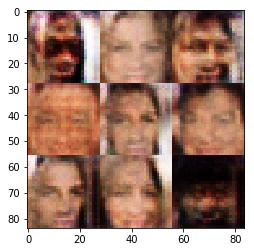

Step 1210... Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.6169
Step 1220... Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6820
Step 1230... Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.8187
Step 1240... Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6561
Step 1250... Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7537
Step 1260... Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6129
Step 1270... Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6245
Step 1280... Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7094
Step 1290... Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6563
Step 1300... Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7383


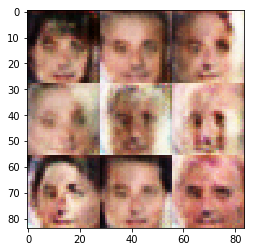

Step 1310... Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.7549
Step 1320... Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.8883
Step 1330... Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6888
Step 1340... Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7005
Step 1350... Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.7900
Step 1360... Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.6891
Step 1370... Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6546
Step 1380... Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.5995
Step 1390... Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.6988
Step 1400... Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6830


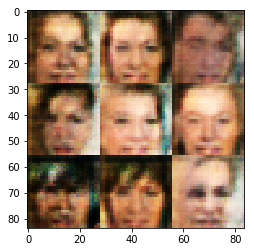

Step 1410... Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.6433
Step 1420... Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6771
Step 1430... Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6992
Step 1440... Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6432
Step 1450... Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6330
Step 1460... Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6816
Step 1470... Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.6210
Step 1480... Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7313
Step 1490... Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6229
Step 1500... Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.5922


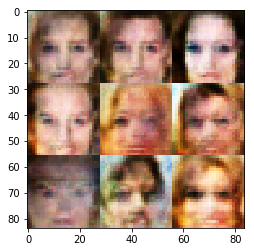

Step 1510... Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6368
Step 1520... Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6482
Step 1530... Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7208
Step 1540... Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6615
Step 1550... Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6479
Step 1560... Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7267
Step 1570... Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7213
Step 1580... Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.6488
Step 1590... Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.6071
Step 1600... Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6477


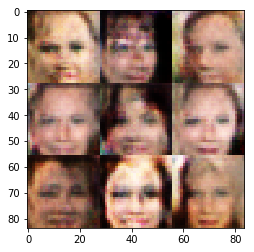

Step 1610... Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6541
Step 1620... Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7352
Step 1630... Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7747
Step 1640... Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6291
Step 1650... Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6358
Step 1660... Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7460
Step 1670... Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7271
Step 1680... Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.7584
Step 1690... Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6372
Step 1700... Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6646


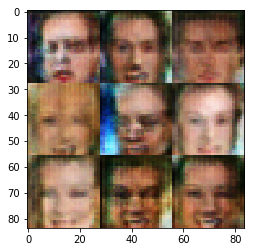

Step 1710... Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7066
Step 1720... Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7688
Step 1730... Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7149
Step 1740... Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7026
Step 1750... Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7513
Step 1760... Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 0.6091
Step 1770... Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.5490
Step 1780... Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.6897
Step 1790... Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.6658
Step 1800... Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7524


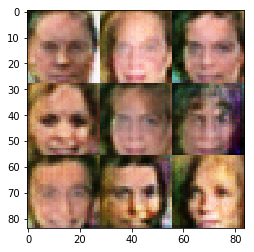

Step 1810... Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.6757
Step 1820... Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7277
Step 1830... Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6924
Step 1840... Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6958
Step 1850... Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7667
Step 1860... Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.6504
Step 1870... Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6925
Step 1880... Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.5826
Step 1890... Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7189
Step 1900... Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.6963


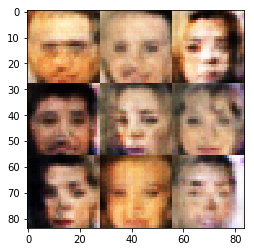

Step 1910... Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.6584
Step 1920... Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7091
Step 1930... Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6533
Step 1940... Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7635
Step 1950... Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6052
Step 1960... Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.5889
Step 1970... Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7460
Step 1980... Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6737
Step 1990... Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7376
Step 2000... Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7255


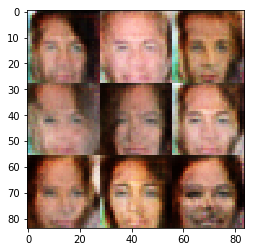

Step 2010... Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6845
Step 2020... Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.6639
Step 2030... Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.6109
Step 2040... Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7144
Step 2050... Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6375
Step 2060... Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.7424
Step 2070... Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6352
Step 2080... Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6702
Step 2090... Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.6210
Step 2100... Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7118


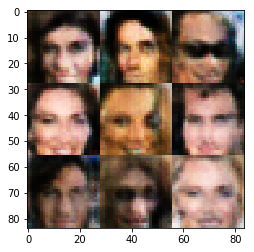

Step 2110... Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.7278
Step 2120... Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7008
Step 2130... Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.5616
Step 2140... Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6487
Step 2150... Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.7565
Step 2160... Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.6955
Step 2170... Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7699
Step 2180... Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.5362
Step 2190... Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.5791
Step 2200... Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7043


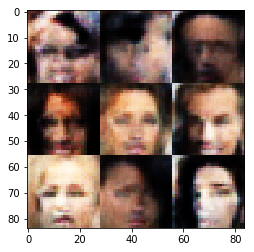

Step 2210... Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6693
Step 2220... Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6892
Step 2230... Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.6992
Step 2240... Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6775
Step 2250... Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.7531
Step 2260... Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.7555
Step 2270... Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.5609
Step 2280... Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.8069
Step 2290... Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.6109
Step 2300... Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6690


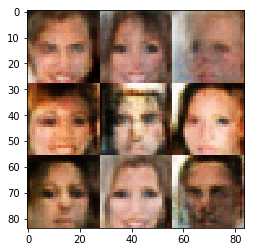

Step 2310... Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.7831
Step 2320... Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7358
Step 2330... Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6423
Step 2340... Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.6281
Step 2350... Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6403
Step 2360... Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7066
Step 2370... Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6760
Step 2380... Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.6777
Step 2390... Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.5797
Step 2400... Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.6759


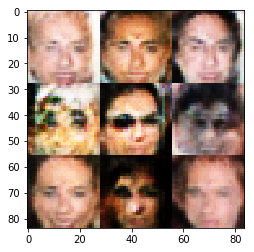

Step 2410... Epoch 1/1... Discriminator Loss: 1.6635... Generator Loss: 0.5393
Step 2420... Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6640
Step 2430... Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6096
Step 2440... Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.6093
Step 2450... Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6485
Step 2460... Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6237
Step 2470... Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7033
Step 2480... Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6801
Step 2490... Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6698
Step 2500... Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6951


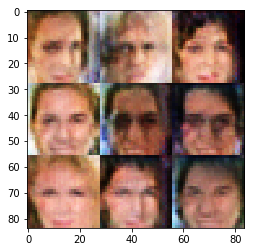

Step 2510... Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7756
Step 2520... Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.5908
Step 2530... Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7132
Step 2540... Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.5958
Step 2550... Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7373
Step 2560... Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.5470
Step 2570... Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7104
Step 2580... Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.6636
Step 2590... Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7188
Step 2600... Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6152


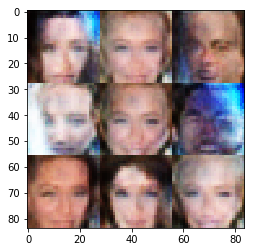

Step 2610... Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.6105
Step 2620... Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7170
Step 2630... Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7989
Step 2640... Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7710
Step 2650... Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6828
Step 2660... Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.7228
Step 2670... Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.5565
Step 2680... Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.6038
Step 2690... Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6452
Step 2700... Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6948


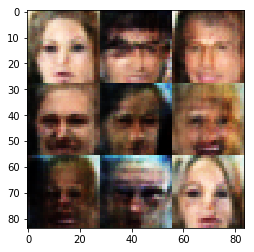

Step 2710... Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.7225
Step 2720... Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.6139
Step 2730... Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.6260
Step 2740... Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6648
Step 2750... Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.6794
Step 2760... Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.5847
Step 2770... Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6590
Step 2780... Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6747
Step 2790... Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.6935
Step 2800... Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6780


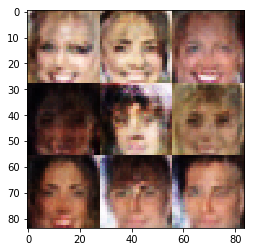

Step 2810... Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.6678
Step 2820... Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7318
Step 2830... Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6650
Step 2840... Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7003
Step 2850... Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6858
Step 2860... Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.6293
Step 2870... Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6322
Step 2880... Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7040
Step 2890... Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6800
Step 2900... Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.7515


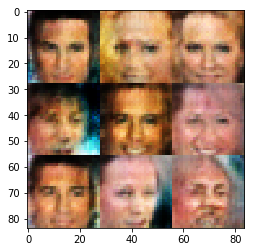

Step 2910... Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7179
Step 2920... Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6415
Step 2930... Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.6328
Step 2940... Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6519
Step 2950... Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.6562
Step 2960... Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6564
Step 2970... Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.7708
Step 2980... Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7325
Step 2990... Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6617
Step 3000... Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7167


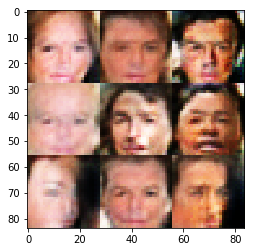

Step 3010... Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.6134
Step 3020... Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7137
Step 3030... Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.7109
Step 3040... Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6897
Step 3050... Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7346
Step 3060... Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7645
Step 3070... Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6255
Step 3080... Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6957
Step 3090... Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.7023
Step 3100... Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7299


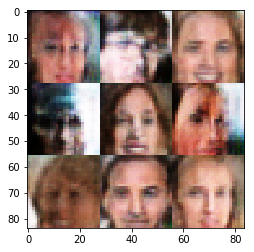

Step 3110... Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8083
Step 3120... Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7621
Step 3130... Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6351
Step 3140... Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6541
Step 3150... Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.7645
Step 3160... Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6266
Step 3170... Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6938
Step 3180... Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6467
Step 3190... Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.6387
Step 3200... Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.6229


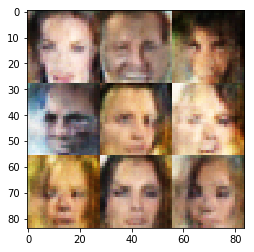

Step 3210... Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6924
Step 3220... Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.7082
Step 3230... Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7102
Step 3240... Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.5987
Step 3250... Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.8171
Step 3260... Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6885
Step 3270... Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7436
Step 3280... Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6849
Step 3290... Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6615
Step 3300... Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7473


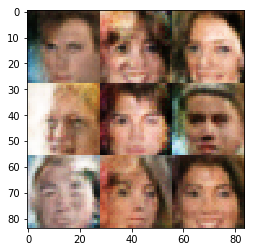

Step 3310... Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6606
Step 3320... Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6838
Step 3330... Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6713
Step 3340... Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.6668
Step 3350... Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6809
Step 3360... Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7566
Step 3370... Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7739
Step 3380... Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.6499
Step 3390... Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7081
Step 3400... Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6648


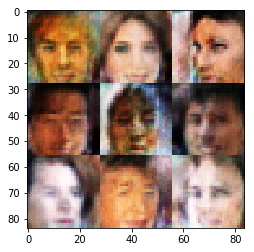

Step 3410... Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.6871


KeyboardInterrupt: 

In [25]:
batch_size = 32
z_dim = 500
learning_rate = 0.0005
beta1 = 0.35


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.